<a href="https://colab.research.google.com/github/AayushiChoudhary01/PaAC-project/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D,GlobalAvgPool2D, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras import Sequential, models, datasets
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils, Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [ ]:
!pip install astroNN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 31.0 MB/s eta 0:00:00


In [ ]:
from astroNN.datasets import galaxy10sdss

In [ ]:
X, y = galaxy10sdss.load_data()
X = X.astype(np.float32)/255
print(X.shape)

Galaxy10.h5: 100%|█████████▉| 210M/210M [00:08<00:00, 32.9MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:09, 21.3MB/s]                           


(21785, 69, 69, 3)


In [ ]:
y[:5]
y=y.reshape(-1)
print(y[:5])

[2 2 4 2 4]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class Sample(tf.keras.layers.Layer):
 def call(self, input):
  mean, log_var = input
  return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:
latent_size = 2

en_input = tf.keras.layers.Input(shape=[69, 69,3])
Z= Conv2D(32, 3, padding = 'same', activation = 'relu')(en_input)
Z= Conv2D(64, 3, padding = 'same', activation = 'relu')(Z)

Z = Flatten()(Z)
Z = Dense(150, activation="relu")(Z)
Z = Dense(100, activation="relu")(Z)

Z_mean = Dense(latent_size)(Z)
Z_log_var = Dense(latent_size)(Z)
Z = Sample()([Z_mean, Z_log_var])

var_encoder = tf.keras.Model(
inputs=[en_input], outputs=[Z_mean, Z_log_var, Z], name = 'var_encoder')

print(var_encoder.summary())

Model: "var_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 69, 69, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 69, 69, 32)           896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 69, 69, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 304704)               0         ['conv2d_1[0][0]']            
                                                                                        

In [ ]:
de_inputs = tf.keras.layers.Input(shape=[latent_size])

x = Dense(17 * 17 * 32, activation="relu")(de_inputs)

x = Reshape((17, 17, 32))(x)

x = Conv2DTranspose(32, 3, strides=2, activation="relu", padding='same')(x)
x = Conv2DTranspose(16, 3, strides=2, activation="relu")(x)

outputs = Conv2DTranspose(3, (3, 3), activation='relu', padding='same')(x)

var_decoder = tf.keras.Model(inputs=[de_inputs], outputs=
[outputs])

print(var_decoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 9248)              27744     
                                                                 
 reshape (Reshape)           (None, 17, 17, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 34, 34, 32)        9248      
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 69, 69, 16)        4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 69, 69, 3)         435   

In [ ]:
_, _, Z = var_encoder(en_input)
reconstructions = var_decoder(Z)
var_ae = tf.keras.Model(inputs=[en_input], outputs=[reconstructions])

In [ ]:
latent_loss = -0.5 * tf.reduce_sum(
1 + Z_log_var - tf.exp(Z_log_var) - tf.square(Z_mean),
axis=-1)
var_ae.add_loss(tf.reduce_mean(latent_loss) / (69*69*3))  # write the full value in the multipilcation

In [ ]:
var_ae.compile(loss="mse", optimizer="nadam")
var_ae.fit(X_train, X_train, epochs=15, batch_size=32,
validation_data=(X_test, X_test))

Epoch 1/15
545/545 [==============================] - 39s 52ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 2/15
545/545 [==============================] - 26s 48ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 3/15
545/545 [==============================] - 29s 52ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 4/15
545/545 [==============================] - 29s 54ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 5/15
545/545 [==============================] - 28s 51ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/15
545/545 [==============================] - 27s 49ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/15
545/545 [==============================] - 28s 50ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 8/15
545/545 [==============================] - 27s 49ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/15
545/545 [==============================] - 27s 49ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/15
545/545 [==============================] - 26s 49ms/step - loss: 0.002

137/137 [==============================] - 2s 12ms/step


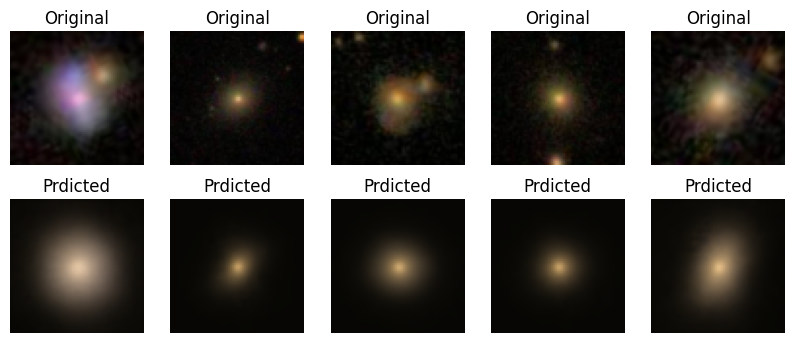

In [ ]:
predicted_images = var_ae.predict(X_test)

n_images = 5
plt.figure(figsize=(10, 4))

for i in range(n_images):

    ax = plt.subplot(2, n_images, i + 1)
    plt.imshow(X_test[i])
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, n_images, i + n_images + 1)
    plt.imshow(predicted_images[i])
    plt.title("Prdicted")
    plt.axis("off")

plt.show()

In [ ]:
encoder = Model(en_input, Z_mean)

In [ ]:
encoded_data = encoder.predict(X_train)


545/545 [==============================] - 2s 4ms/step


In [ ]:
encoded_data.shape

(17428, 2)

In [ ]:
encoded_data_reshaped = np.reshape(encoded_data, (encoded_data.shape[0], 1, 1, encoded_data.shape[1]))

In [ ]:
# this one is giving errors in training
cnn = Sequential([
    Conv2D(32, (1, 1), activation='relu', input_shape=(1, 1, 2)),
    Flatten(),
    Dense(units = 32, activation='relu'),
    Dense(units = 10, activation='softmax')
])

In [ ]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
encoded_data_test = encoder.predict(X_test)

137/137 [==============================] - 1s 4ms/step


In [ ]:
encoded_data_test_reshaped = np.reshape(encoded_data_test, (encoded_data_test.shape[0], 1, 1, encoded_data_test.shape[1]))

In [ ]:
y_train_encoded = to_categorical(y_train, 10)
y_test_encoded = to_categorical(y_test, 10)



In [ ]:
ann = Sequential([
    Dense(64, activation='relu', input_shape=encoded_data_shape),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(units = 10, activation='softmax')
])

In [ ]:
ann.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'], run_eagerly = True)

In [ ]:
history = ann.fit(encoded_data, y_train_encoded, validation_data = (encoded_data_test, y_test_encoded), epochs = 10)

Epoch 1/10
545/545 [==============================] - 23s 40ms/step - loss: 1.8123 - accuracy: 0.3502 - val_loss: 1.5555 - val_accuracy: 0.4616
Epoch 2/10
545/545 [==============================] - 18s 34ms/step - loss: 1.6115 - accuracy: 0.4221 - val_loss: 1.4827 - val_accuracy: 0.4923
Epoch 3/10
545/545 [==============================] - 19s 35ms/step - loss: 1.5660 - accuracy: 0.4531 - val_loss: 1.4625 - val_accuracy: 0.4930
Epoch 4/10
545/545 [==============================] - 18s 34ms/step - loss: 1.5492 - accuracy: 0.4602 - val_loss: 1.4554 - val_accuracy: 0.4987
Epoch 5/10
545/545 [==============================] - 20s 36ms/step - loss: 1.5297 - accuracy: 0.4673 - val_loss: 1.4507 - val_accuracy: 0.5049
Epoch 6/10
545/545 [==============================] - 18s 34ms/step - loss: 1.5213 - accuracy: 0.4710 - val_loss: 1.4416 - val_accuracy: 0.5047
Epoch 7/10
545/545 [==============================] - 18s 33ms/step - loss: 1.5108 - accuracy: 0.4745 - val_loss: 1.4397 - val_accuracy: